In [2]:
from gurobipy import *
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt


In [8]:
# ---------- Data ----------
with open('data_small.txt', 'r') as f:
    data = f.readlines()

CVRPTW = []
i = 0
for line in data:
    i=i+1
    words = line.split()
    words=[int(i) for i in words]
    CVRPTW.append(words)

CVRPTW = np.array(CVRPTW)

N = CVRPTW[:,0]                 # nodes
n = len(N)                      # number of nodes

V = {0}

xcoord = CVRPTW[:,1]            # x coordinates
ycoord = CVRPTW[:,2]            # y coordinates
q = CVRPTW[:,3]                 # demand
s = CVRPTW[:,4]                 # service time
a = CVRPTW[:,5]                 # ready time
b = CVRPTW[:,6]                 # due date
Q = 130                         # vehicle capacity
M = 1234                      # big M

# distance matrix   
d = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        d[i,j] = math.sqrt((xcoord[i]-xcoord[j])**2 + (ycoord[i]-ycoord[j])**2) 
        if i == j:
            d[i, j] = M  # Set a large penalty for self-loops


# ---------- Optimization Model ----------

m = Model("CVRPTW")

# Variables
# if arc (i,j) is used in the solution by vehicle v
x = {}
for i in N:
    for j in N:
        for v in V:
            x[i,j,v] = m.addVar(vtype=GRB.BINARY, lb = 0, name='X_%s_%s_%s' % (i, j, v))

# time vehicle v starts service at node i
t = {}
for i in N:
    for v in V:
        t[i,v] = m.addVar(vtype=GRB.CONTINUOUS, lb = 0, name='t_%s_%s' % (i, v))

# if node i is visited by vehicle v
z = {}
for i in N:
    for v in V:
        z[i,v] = m.addVar(vtype=GRB.BINARY, lb = 0, name='z_%s_%s' % (i, v))

# order for sub-tour elimination
u = {}
for i in N:
    u[i] = m.addVar(vtype=GRB.INTEGER, lb = 0, name='u_%s' % (i))

# Objective Function
obj = quicksum(d[i,j]*x[i,j,v] for i in N for j in N for v in V)
m.setObjective(obj)
m.ModelSense = GRB.MINIMIZE
m.update()

# Constraints

# each node is visited by exactly one vehicle
con1 = {}
for i in N:
    if i != 0:
        con1[i] = m.addConstr(
            quicksum(x[i,j,v] for v in V for j in N if j != i) == 1, 'con1[' + str(i) + ']'
        )
    

# each vehicle starts and ends at the depot
con2 = {}
con3 = {}
for v in V:
    con2[v] = m.addConstr(
        quicksum(x[0,i,v] for i in N) == 1, 'con2[' + str(v) + ']'
    )


# Capacity constraint
con4 = {}
#for v in V:
 #   con4[v] = m.addConstr(
  #      quicksum(q[i]*x[i,j,v] for i in N for j in N) <= Q, 'con4[' + str(v) + ']'
   # )


# Flow conservation excluding self-loops
con5 = {}
for h in N:
    for v in V:
        con5[i, v] = m.addConstr(
            quicksum(x[i, h, v] for i in N) == quicksum(x[h, j, v] for j in N),
            'con5[' + str(i) + ',' + str(v) + ']'
        )


# time window constraints
con6 = {}
con7 = {}
con8 = {}
for i in N:
    for v in V:
        con6[i,v] = m.addConstr(
            t[i,v] >= a[i], 'con6[' + str(i) + ',' + str(v) + ']'
            )
        con7[i,v] = m.addConstr(
            t[i,v] <= b[i], 'con7[' + str(i) + ',' + str(v) + ']'
            )

for i in N:
    for j in N:
        for v in V:
            if i != j and i != 0 and j != 0:
                con8[i,j,v] = m.addConstr(
                    t[j,v] >= t[i,v] + s[i] + d[i,j] - M*(1-x[i,j,v]), 'con8[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
                    )




# Solve
m.update()
m.write('CVRPTW.lp')
m.Params.TimeLimit = 3600
m.optimize()



Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 92 rows, 108 columns and 403 nonzeros
Model fingerprint: 0xf77a7a36
Variable types: 9 continuous, 99 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [4e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 1 rows and 27 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [6]:
for v in V:
    print(f"Vehicle {v}:")
    for i in N:
        for j in N:
            if x[i, j, v].X > 0.5:
                print(f"x[{i},{j},{v}] = {x[i, j, v].X}")
    print("\n")

Vehicle 0:
x[0,6,0] = 1.0
x[1,7,0] = 1.0
x[2,5,0] = 1.0
x[3,4,0] = 1.0
x[4,3,0] = 1.0
x[5,2,0] = 1.0
x[6,8,0] = 1.0
x[7,1,0] = 1.0
x[8,0,0] = 1.0




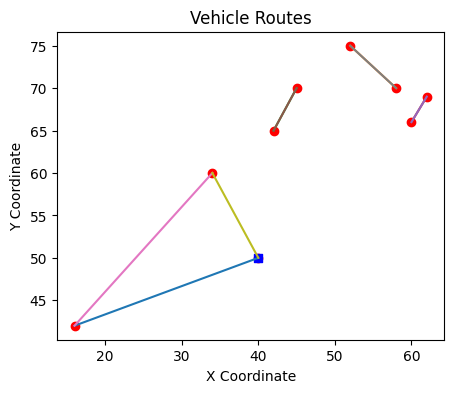

In [7]:
# Extract the routes from the solution
routes = {v: [] for v in V}
if m.status == GRB.OPTIMAL:
    for v in V:
        for i in N:
            for j in N:
                if x[i, j, v].X > 0.5:
                    routes[v].append((i, j))

    # Plot the routes
    plt.figure(figsize=(5, 4))
    plt.scatter(xcoord, ycoord, c='red')
    plt.scatter(xcoord[0], ycoord[0], c='blue', marker='s')  # depot

    for v in V:
        for (i, j) in routes[v]:
            plt.plot([xcoord[i], xcoord[j]], [ycoord[i], ycoord[j]], label=f'Vehicle {v}')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.show()
else:
    print("No optimal solution found.")